# Projekt Dno Oka
## Autorzy
- Jędrzej Warczyński 148234
- Uladzislau Abeziuk 150243

## Wykorzytyswane biblioteki

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from imblearn.under_sampling import RandomUnderSampler

import pickle

from tqdm import tqdm
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from python_files.image_reader import ImageReader
from python_files.feature_extractor import FeatureExtractor
from python_files.recognition import preprocess, apply_fov_mask
from python_files.metrics_visualizer import MetricsVisualizer
from python_files.constants import *

## Wczytanie danych

In [2]:
train_filename = file_names[0]
img_reader = ImageReader(IMAGES_FOLDER, MANUAL_FOLDER, MASK_FOLDER)

In [3]:
train_img = img_reader.read_img(train_filename)
train_expert_mask = img_reader.read_manual(train_filename)
train_fov_mask = img_reader.read_mask(train_filename)

## Wstępne przetworzenie danych
- ekstrakcja składowje zielonej
- zastosowanie rozmycia medianowego
- zastosowanie normalizacji histogramu

In [4]:
train_img = preprocess(train_img)

## Ekstrakcja cech
- oryginalny obraz
- wykrycie krawędzi
- filtracja medianowa
- filtr gabora
- filtr gasussa

In [5]:
feature_extractor = FeatureExtractor(train_img)
features = feature_extractor.extract_features()

In [ ]:
# features.head()

In [6]:
Y = train_expert_mask.flatten()

## Under sampling ze względu na niezbalansowane dane

In [7]:
rus = RandomUnderSampler(random_state=42)
X_undersample, Y_undersample = rus.fit_resample(features, Y)

## Podział na zbiór treningowy i testowy oraz zdefinowanie modelu RandomForestClassifier

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_undersample, Y_undersample, test_size=0.4, random_state=20)
model = RandomForestClassifier(n_estimators=100, random_state=42)

## Trenowanie modelu

In [10]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Testowanie modelu

In [11]:
prediction_test = model.predict(X_test)
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.8716256388390096


## Wyznaczenie ważności cech

In [12]:
# importance = list(model.feature_importances_)
# feature_list = features.columns
# feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
# print(feature_imp)

## Zapisanie modelu do pliku

In [7]:
model_name = "random_forest_model"
model_path = os.path.join(MODELS_FOLDER, model_name)

In [14]:
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

## Wczytanie zdjęć testowych

In [4]:
test_images = []
test_expert_masks = []
test_fov_masks = []
for file_name in tqdm(file_names[-5:], total=5):
    test_img_reader = ImageReader(IMAGES_FOLDER, MANUAL_FOLDER, MASK_FOLDER)
    test_images.append(test_img_reader.read_img(file_name))
    test_expert_masks.append(test_img_reader.read_manual(file_name))
    test_fov_masks.append(test_img_reader.read_mask(file_name))

100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


## Wstępne przetworzenie zdjęć testowych i ekstrakcja cech

In [5]:
test_features = []
for i, test_img in tqdm(enumerate(test_images), total=5):
    test_images[i] = preprocess(test_img)
    test_img_feature_extractor = FeatureExtractor(test_images[i])
    test_features.append(test_img_feature_extractor.extract_features())

100%|██████████| 5/5 [00:29<00:00,  5.94s/it]


## Wczytanie modelu i segmentacja

In [8]:
segmented_images = []
loaded_model = pickle.load(open(model_path, 'rb'))
for i, test_feature in tqdm(enumerate(test_features), total=5):
    test_img_segmented = loaded_model.predict(test_feature)
    test_img_segmented = test_img_segmented.reshape(test_images[i].shape)
    test_img_segmented = apply_fov_mask(test_img_segmented, test_fov_masks[i])
    segmented_images.append(test_img_segmented)

100%|██████████| 5/5 [13:29<00:00, 161.99s/it]


## Wyznaczenie metryk

In [9]:
metrics_visualizer = MetricsVisualizer()
for expert_mask, segmented_image, file_name in zip(test_expert_masks, segmented_images, file_names[-5:]):
    metrics_visualizer.calculate_metrics(expert_mask, segmented_image, file_name)

## Wizualizacja wyników
- na czerowono: błednie wykryte naczynie krwionośne przez model
- na niebiesko: błednie nie wykryte naczynie krwionośne przez model

Image        Accuracy    Sensitivity    Specificity      TP           TN                FP      FN
---------  ----------  -------------  -------------  ------  -----------  ----------------  ------
14_g.jpg     0.891895       0.817481       0.897551  472642  6.82783e+06  779346            105527
14_h.jpg     0.885066       0.843634       0.889026  602400  6.64217e+06  829121            111654
15_dr.JPG    0.84552        0.84447        0.845593  451828  6.46904e+06       1.18126e+06   83215
15_g.jpg     0.894238       0.792034       0.90231   474577  6.84506e+06  741091            124611
15_h.jpg     0.913844       0.819674       0.921848  525612  6.95451e+06  589585            115633
mean         0.886113       0.823459       0.891266  505412  6.74772e+06  824080            108128


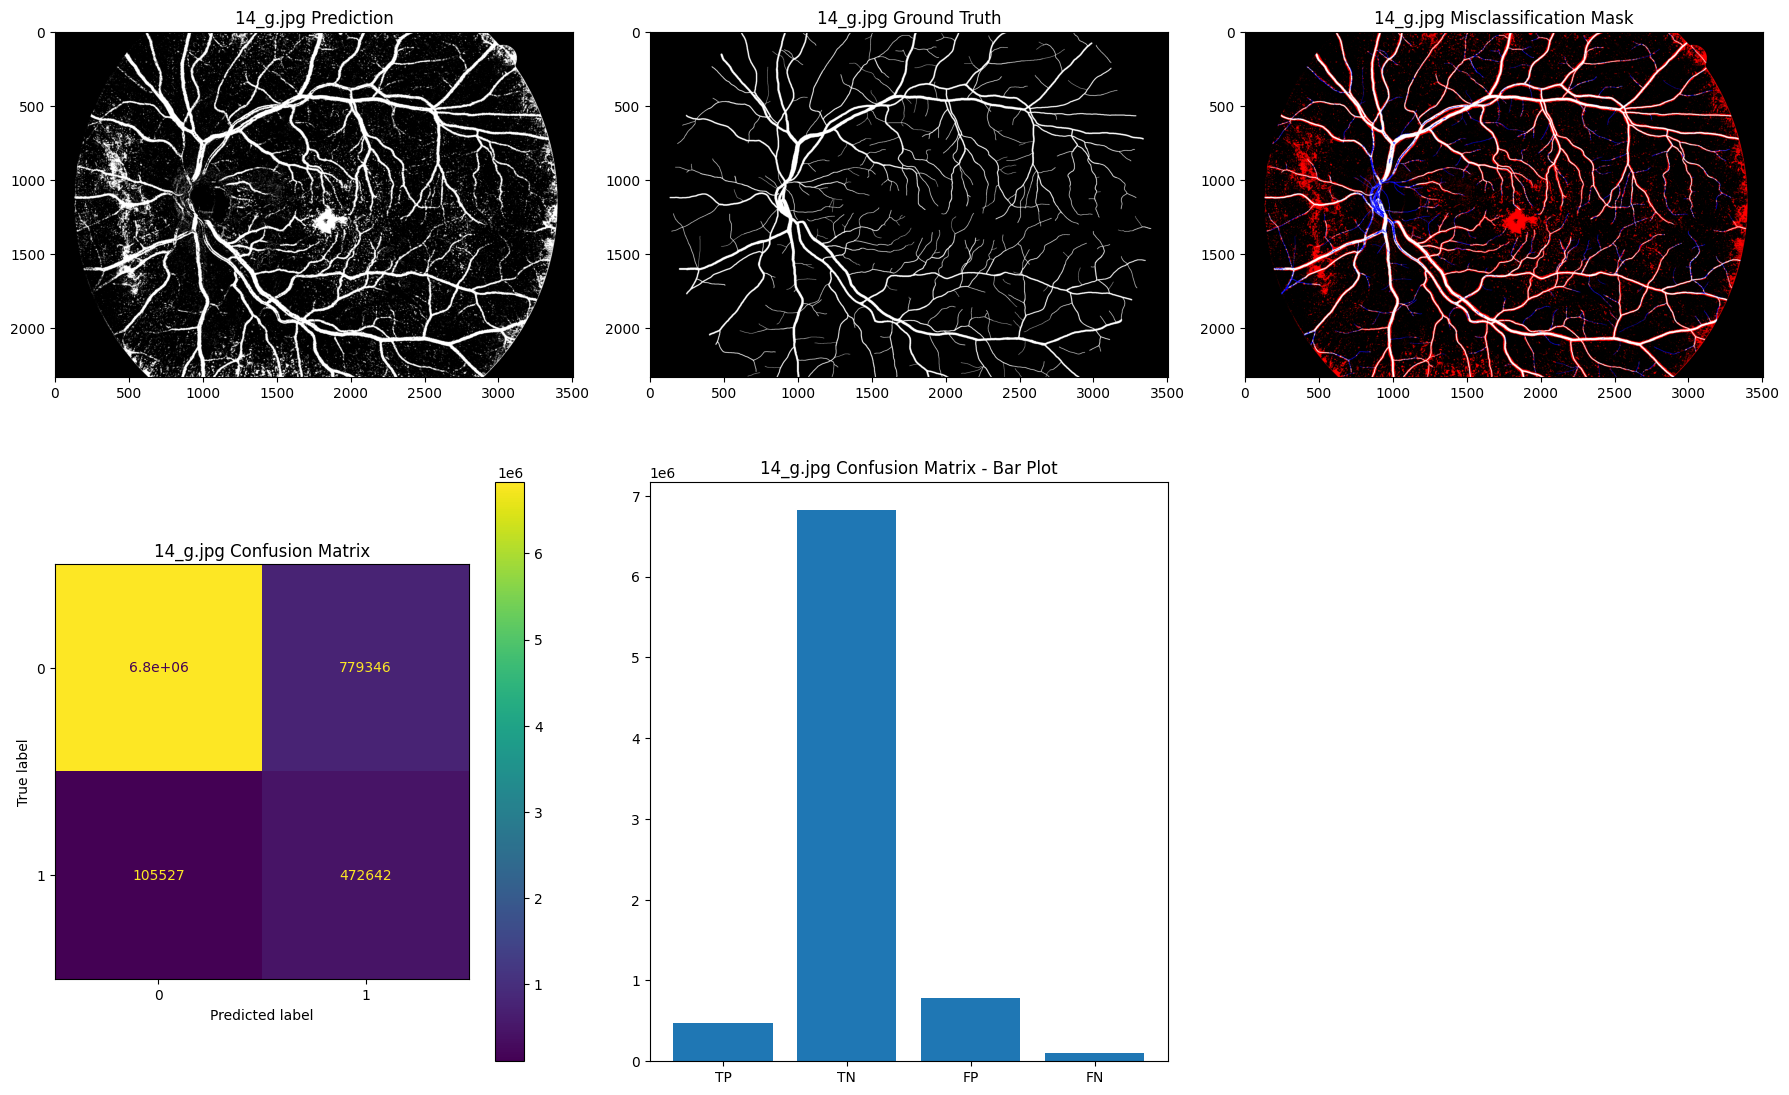

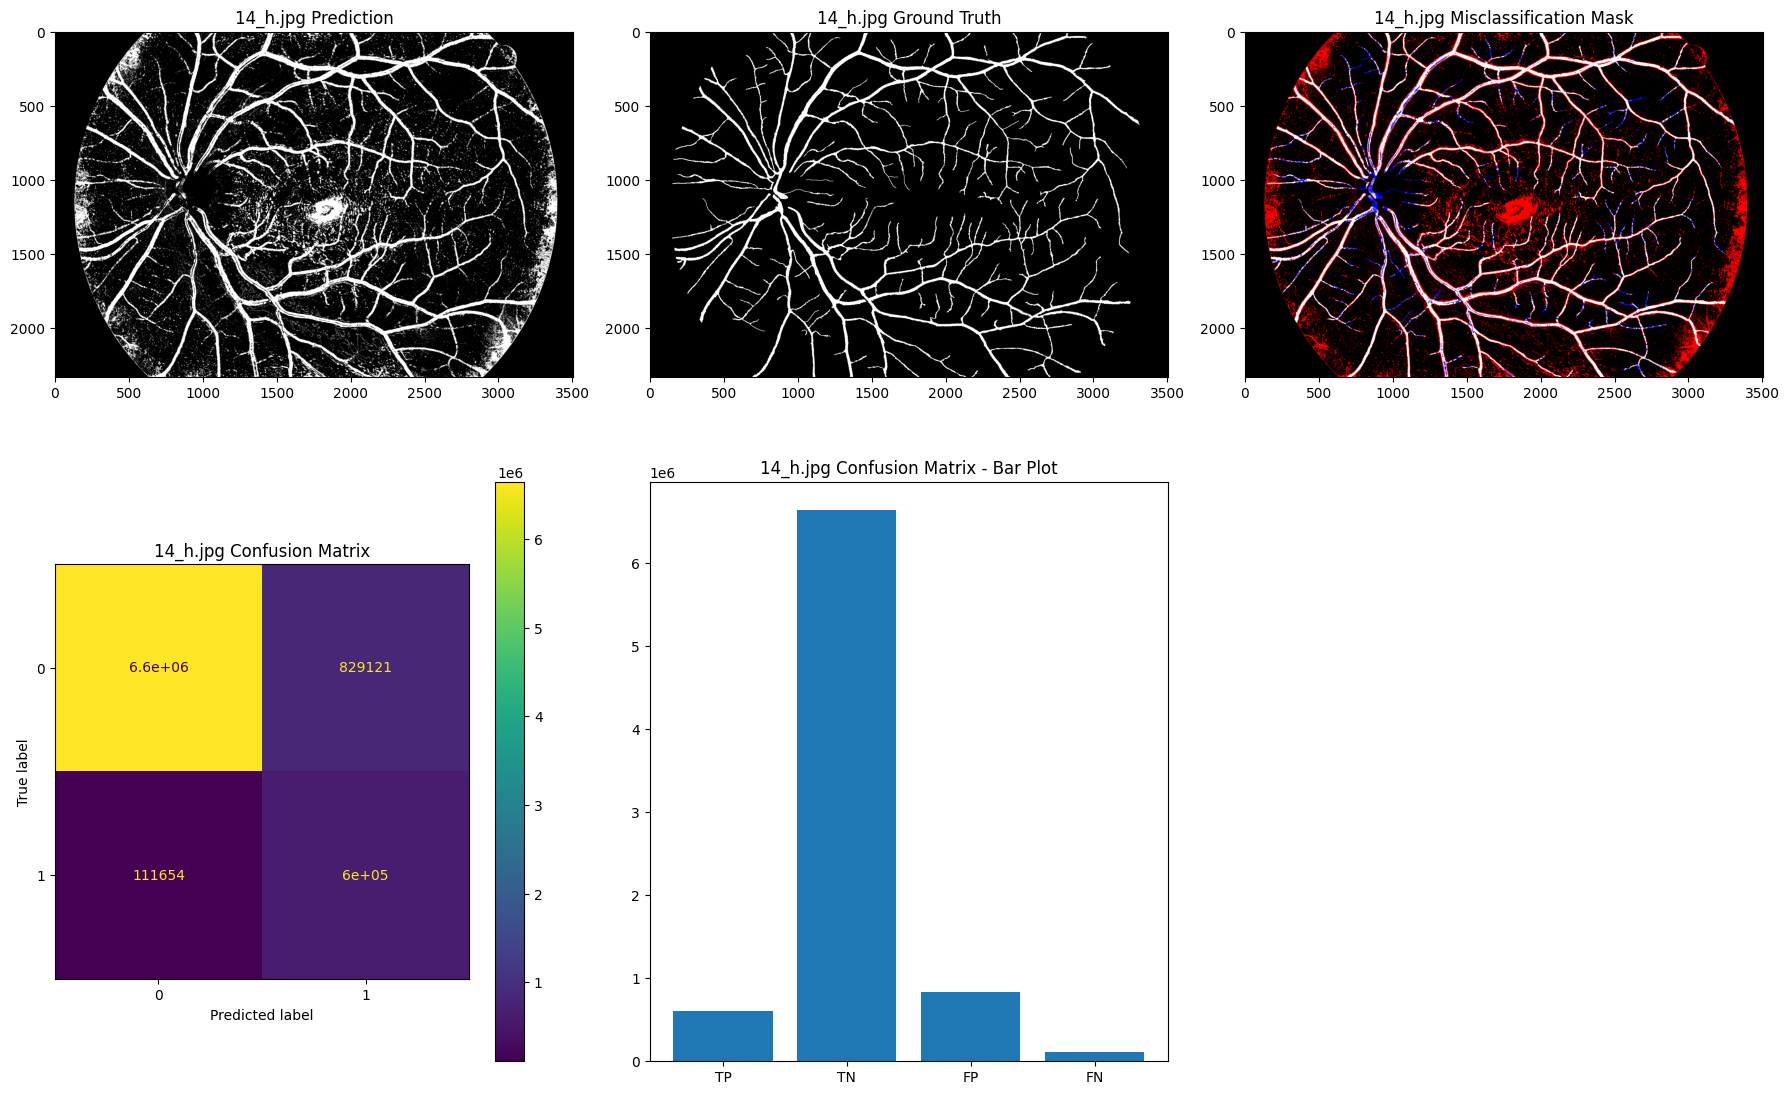

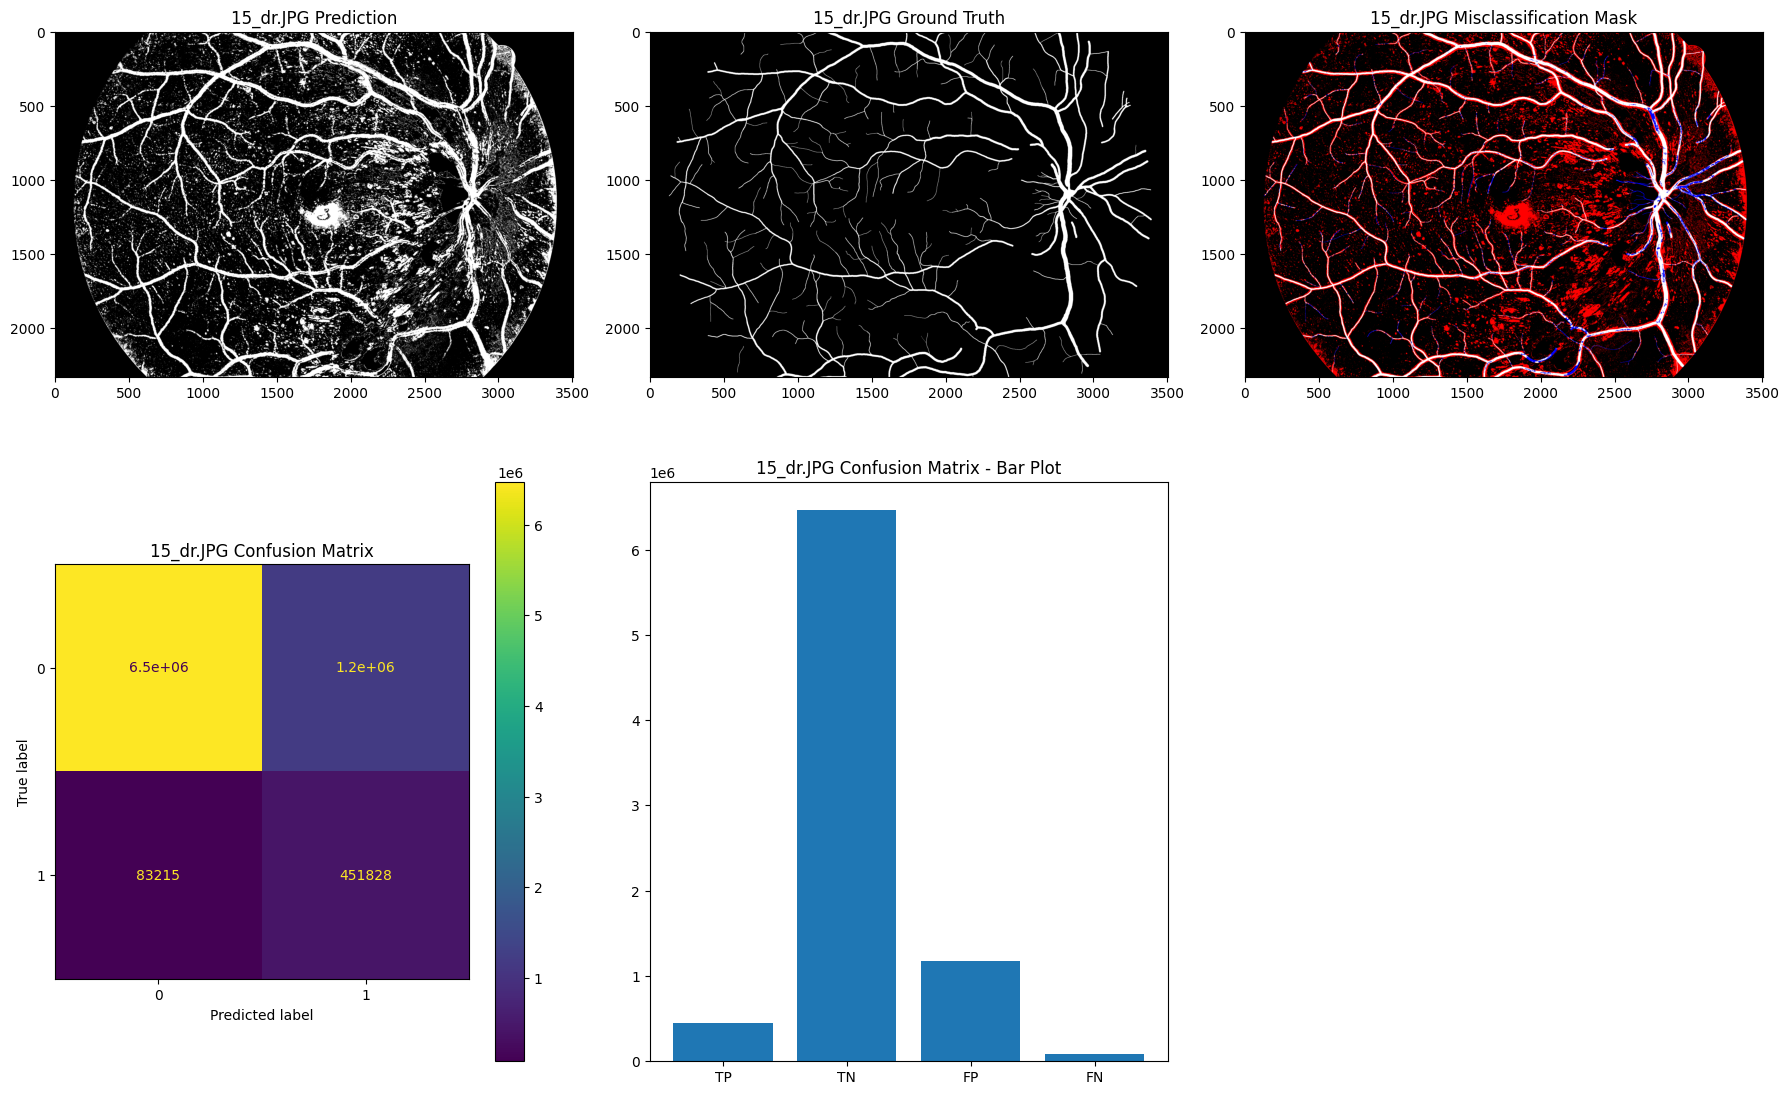

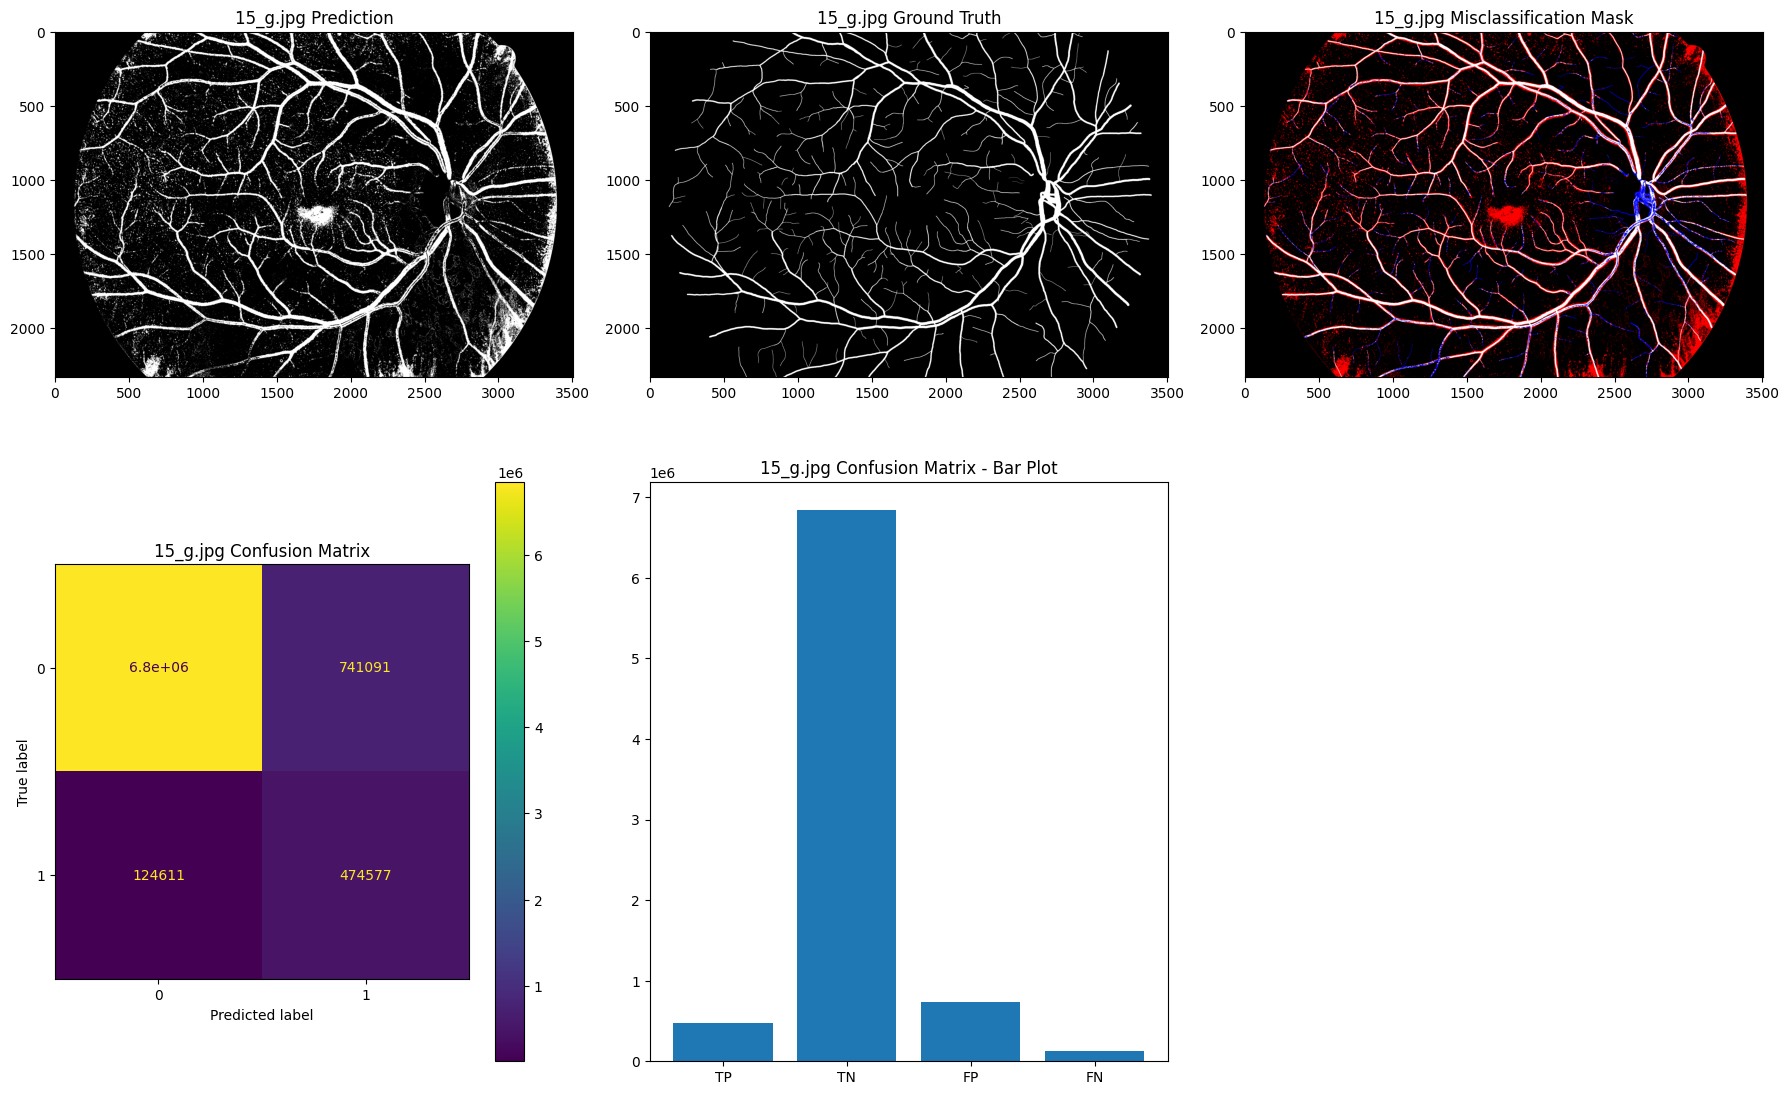

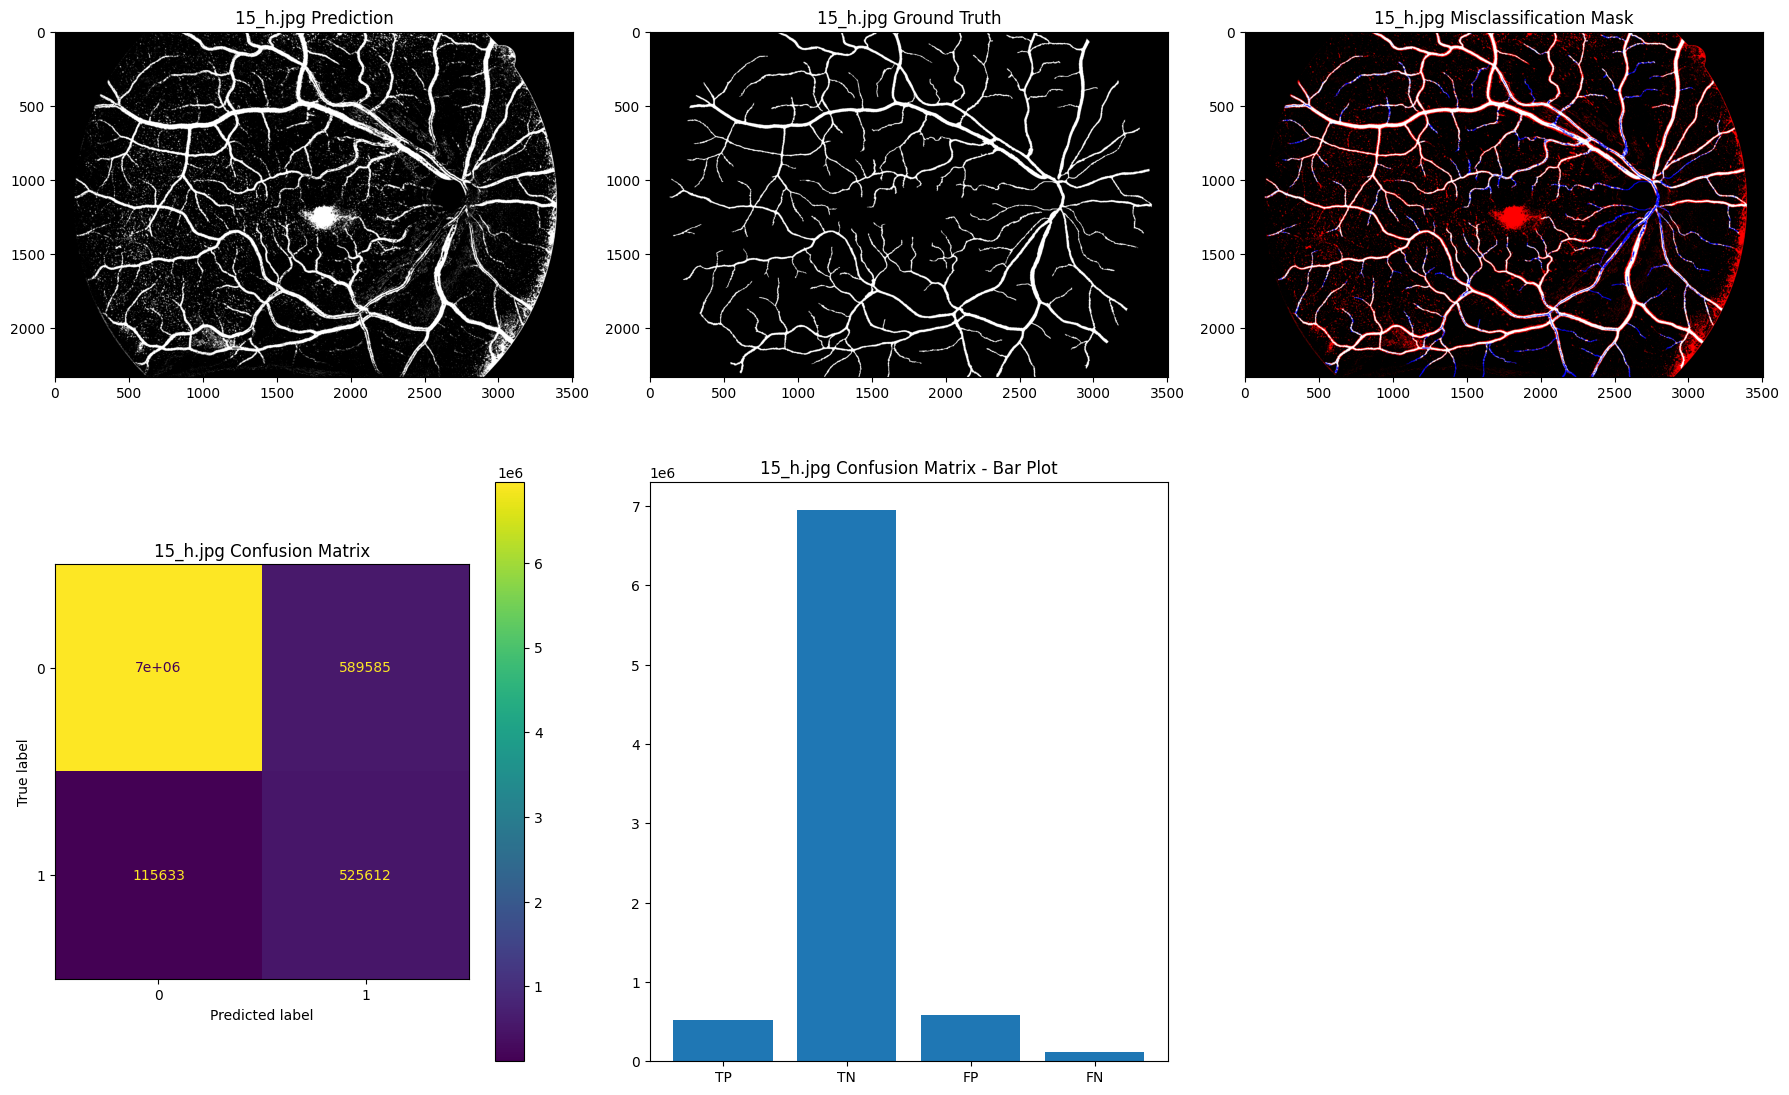

In [10]:
metrics_visualizer.visualize()

## Uzasadnienie wyboru modelu i metod ekstrakcji cech
1. Bogate cechy: Wykorzystanie różnych przetwarzanych wariantów obrazu jako cech może pomóc w wydobyciu różnorodnych informacji na temat naczyń krwionośnych. Oryginalny obraz może zawierać ogólne informacje o jasności i kontrastowości, wykrywanie krawędzi może uwypuklić struktury naczyń, a filtry medianowy, Gabora i Gaussa mogą wyodrębnić dodatkowe cechy związane z kształtem, teksturą i innymi aspektami naczyń krwionośnych.

2. Zdolność Random Forest do uczenia złożonych zależności: Klasyfikator Random Forest ma zdolność do uczenia złożonych zależności między cechami a klasami docelowymi. Może nauczyć się, jak cechy przetworzone różnymi metodami są powiązane z obecnością naczyń krwionośnych. Dzięki temu model może efektywnie wykorzystać różnorodne cechy ekstrahowane z obrazów do dokładnej klasyfikacji pikseli jako należących do naczyń lub nie.

3. Zastosowanie dużej liczby estymatorów: Wybranie wartości n_estimators=100 oznacza, że model zostanie zbudowany na podstawie 100 drzew decyzyjnych. Większa liczba drzew może zwiększyć różnorodność i stabilność predykcji, zmniejszając ryzyko przeuczenia. Dzięki temu model może lepiej radzić sobie z różnorodnością i złożonością danych, co może przekładać się na lepszą segmentację naczyń krwionośnych.